# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
!pip install boost 
!pip install bigartm 

  Created wheel for boost: filename=boost-0.1-cp36-none-any.whl size=12463 sha256=fbb238692aaf732f0549ef97e99ffcedc6614f12367739d8b17745c39c78eb15
  Stored in directory: /root/.cache/pip/wheels/c9/7e/e1/dfb3e41d0b764a6fbb0d926f3dd67c2b729170643ff6558d65
Successfully built boost
     |████████████████████████████████| 1.9MB 6.4MB/s 


In [0]:
import artm

In [0]:
from matplotlib import pyplot as plt
import seaborn as sbs
%matplotlib inline
sbs.set_style("whitegrid", {'axes.grid' : False})

In [0]:
import numpy as np
import pandas as pd

Чтобы загрузить папку с файлами со своего компьютера


##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.


In [0]:
!rm -rf lectures_batches && mkdir lectures_batches

**Нужно загрузить lectures.txt в колаб**

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit', target_folder='lectures_batches', batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text': 1, 'author': 1}, cache_theta=True, reuse_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(data_path=batch_vectorizer.data_path)
model_artm.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name='text_toptokenscore', class_id='text', num_tokens=15, dictionary='dictionary'))
model_artm.scores.add(artm.TopTokensScore(name='author_toptokenscore', class_id='author', num_tokens=15, dictionary='dictionary'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SP', tau=1e5, topic_names='bcg', class_ids='text', dictionary=dictionary))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [11]:
# Ваш код
%%time
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

CPU times: user 17.1 s, sys: 285 ms, total: 17.4 s
Wall time: 11.9 s


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SM', tau=-1e5, topic_names=topic_names[:-1], class_ids='text', dictionary=dictionary))

Выполните еще 15 проходов по коллекции.

In [13]:
# Ваш код
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

CPU times: user 9.19 s, sys: 137 ms, total: 9.33 s
Wall time: 6.43 s


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [14]:
model_artm.score_tracker.keys()

dict_keys(['text_toptokenscore', 'author_toptokenscore'])

**Важно при создании обьекта artm указать reuse_theta=True, без него текст менее информативен**

In [15]:
tlt, alt = model_artm.score_tracker['text_toptokenscore'].last_tokens, model_artm.score_tracker['author_toptokenscore'].last_tokens

for topic_name, text_tokens, author_tokens in zip(tlt.keys(), tlt.values(), alt.values()):
  print(f'{topic_name}: \nText: {text_tokens}\nAuthors: {author_tokens}\n')

sbj0: 
Text: ['римский', 'русь', 'средневековый', 'христианский', 'империя', 'правитель', 'император', 'суд', 'крещение', 'дума', 'имущество', 'рим', 'церковный', 'римлянин', 'соловьев']
Authors: ['Александр_Марей', 'Татьяна_Бобровникова', 'Фёдор_Успенский', 'Владимир_Гимпельсон', 'Кирилл_Соловьев', 'Владимир_Плунгян', 'Владимир_Беликов', 'Михаил_Бойцов', 'Владимир_Малахов', 'Денис_Новак', 'Владимир_Петрухин', 'Ольга_Брилева', 'Алексей_Козырев', 'Алексей_Миллер', 'Татьяна_Клячко']

sbj1: 
Text: ['звезда', 'планета', 'диск', 'спутник', 'солнце', 'солнечный', 'атмосфера', 'попов', 'орбита', 'планетный', 'ледник', 'юпитер', 'космос', 'облако', 'астрономический']
Authors: ['Сергей_Попов', 'Кирилл_Еськов', 'Татьяна_Смоктунович', 'Владимир_Сурдин', 'Александр_Марков', 'Сергей_Наугольных', 'Елизавета_Ривкина', 'Александр_Слободкин', 'Дмитрий_Титов', 'Юлия_Краус', 'Эмиль_Ахмедов', 'Дмитрий_Вибе', 'Сергей_Майоров', 'Андрей_Иванцов', 'Наталья_Новикова']

sbj2: 
Text: ['самка', 'самец', 'уравнени

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [0]:
sbj_topic_labels = [text_tokens[0] for text_tokens in list(tlt.values())[:-1]]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [0]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta, phi_a = model_artm.get_theta(), model_artm.get_phi(class_ids='author')

In [18]:
theta.iloc[:, :100]

,http://postnauka.ru/video/17414,http://postnauka.ru/video/17415,http://postnauka.ru/video/17416,http://postnauka.ru/video/17420,http://postnauka.ru/video/17421,http://postnauka.ru/video/17486,http://postnauka.ru/video/17487,http://postnauka.ru/video/17488,http://postnauka.ru/video/17489,http://postnauka.ru/video/17490,http://postnauka.ru/video/17491,http://postnauka.ru/video/17492,http://postnauka.ru/video/17510,http://postnauka.ru/video/17602,http://postnauka.ru/video/17603,http://postnauka.ru/video/17604,http://postnauka.ru/video/17661,http://postnauka.ru/video/17666,http://postnauka.ru/video/17670,http://postnauka.ru/video/17673,http://postnauka.ru/video/17779,http://postnauka.ru/video/17780,http://postnauka.ru/video/17781,http://postnauka.ru/video/17825,http://postnauka.ru/video/17875,http://postnauka.ru/video/17878,http://postnauka.ru/video/17912,http://postnauka.ru/video/17913,http://postnauka.ru/video/17923,http://postnauka.ru/video/18003,http://postnauka.ru/video/18006,http://postnauka.ru/video/18007,http://postnauka.ru/video/18012,http://postnauka.ru/video/18048,http://postnauka.ru/video/18067,http://postnauka.ru/video/18084,http://postnauka.ru/video/18085,http://postnauka.ru/video/18086,http://postnauka.ru/video/18098,http://postnauka.ru/video/1811,...,http://postnauka.ru/video/18804,http://postnauka.ru/video/18807,http://postnauka.ru/video/18854,http://postnauka.ru/video/18855,http://postnauka.ru/video/18865,http://postnauka.ru/video/18870,http://postnauka.ru/video/18873,http://postnauka.ru/video/18876,http://postnauka.ru/video/1893,http://postnauka.ru/video/1894,http://postnauka.ru/video/1895,http://postnauka.ru/video/18958,http://postnauka.ru/video/1897,http://postnauka.ru/video/1898,http://postnauka.ru/video/1899,http://postnauka.ru/video/18993,http://postnauka.ru/video/19060,http://postnauka.ru/video/19065,http://postnauka.ru/video/19066,http://postnauka.ru/video/19067,http://postnauka.ru/video/19068,http://postnauka.ru/video/19069,http://postnauka.ru/video/19070,http://postnauka.ru/video/19071,http://postnauka.ru/video/19072,http://postnauka.ru/video/19083,http://postnauka.ru/video/19084,http://postnauka.ru/video/19085,http://postnauka.ru/video/19086,http://postnauka.ru/video/19087,http://postnauka.ru/video/19088,http://postnauka.ru/video/19089,http://postnauka.ru/video/19098,http://postnauka.ru/video/19106,http://postnauka.ru/video/19108,http://postnauka.ru/video/19109,http://postnauka.ru/video/1922,http://postnauka.ru/video/1924,http://postnauka.ru/video/19251,http://postnauka.ru/video/1926
sbj0,0.233908,0.027678,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.533339e-07,0.001929,2.029123e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.051994,0.221137,0.002794,0.183644,0.000000,0.000000,7.160125e-03,4.350619e-11,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.580310e-02,...,5.398396e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2.293667e-02,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,9.436211e-10,0.000000,0.000000e+00,0.000000e+00,0.011772,2.145612e-08,0.000000,0.000000,0.000000e+00,0.000000
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,6.895615e-02,0.000000,0.043229,0.000000,0.037799,0.000000e+00,0.004008,0.000000e+00,6.248547e-03,0.000000e+00,3.937823e-08,0.000000e+00,0.000000,0.000000,0.104911,0.080137,0.097595,0.000000,0.000000,0.000000,0.000000,0.000000,0.122420,0.000000e+00,8.636097e-03,0.000000,0.000000,0.000000,0.000000e+00,1.073453e-11,9.216997e-03,0.000000,0.000000e+00,2.409199e-02,...,0.000000e+00,0.000000e+00,0.000729,0.000000,0.002950,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.003322,0.000000e+

In [19]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Евгений_Антипов,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.028393,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Лайман_Пейдж,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.293558e-02,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Юрий_Яшков,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.028118,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Митчел_Резник,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.03932,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Сергей_Майоров,0.0,0.022429,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Кирилл_Мартынов,0.0,0.000000,0.0,0.062858,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.014763,0.0,0.0,0.0,0.0,0.0
Иван_Воробьев,0.0,0.000000,0.0,0.000000,0.0,6.793034e-02,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022882,0.000000,3.308969e-12,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Алексей_Кавокин,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.039385,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Сергей_Карабасов,0.0,0.000000,0.0,0.000000,0.0,6.044047e-10,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.00000,0.000000,0.0,0.000000,0.046231,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

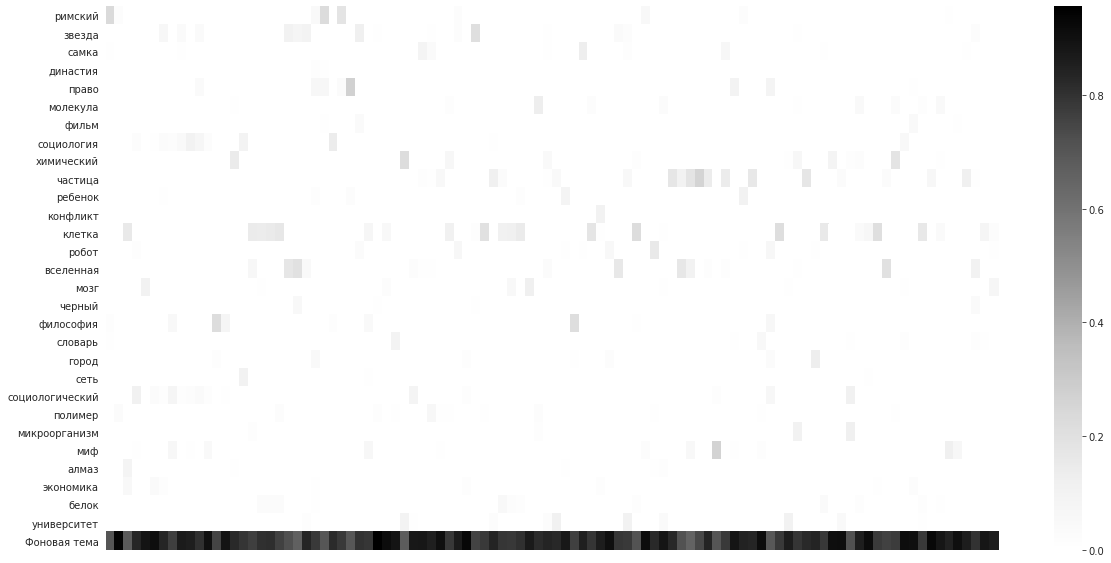

In [20]:
# Ваш код
plt.figure(figsize=(20, 10))
sbs.heatmap(theta.iloc[:, :100], cmap='Greys', xticklabels=False, yticklabels=topic_labels)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [21]:
# Ваш код
T = theta.sum(axis=1) / theta.values.sum()
T.rename(index=dict(zip(T.index, topic_labels)), inplace=True)
T

римский            0.007757
звезда             0.008810
самка              0.003893
династия           0.003384
право              0.005998
молекула           0.004217
фильм              0.004576
социология         0.005348
химический         0.006376
частица            0.011550
ребенок            0.005408
конфликт           0.004444
клетка             0.017803
робот              0.005760
вселенная          0.010825
мозг               0.004880
черный             0.004368
философия          0.010758
словарь            0.002959
город              0.004588
сеть               0.004076
социологический    0.008339
полимер            0.003310
микроорганизм      0.005952
миф                0.008395
алмаз              0.002571
экономика          0.004106
белок              0.006841
университет        0.007067
Фоновая тема       0.815643
dtype: float32

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [0]:
T.sort_values(ascending=False, inplace=True)

In [23]:
Max = 5
Min = 3 
T.iloc[1: Max + 1]

клетка       0.017803
частица      0.011550
вселенная    0.010825
философия    0.010758
звезда       0.008810
dtype: float32

In [24]:
T.iloc[-Min:]

полимер    0.003310
словарь    0.002959
алмаз      0.002571
dtype: float32

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

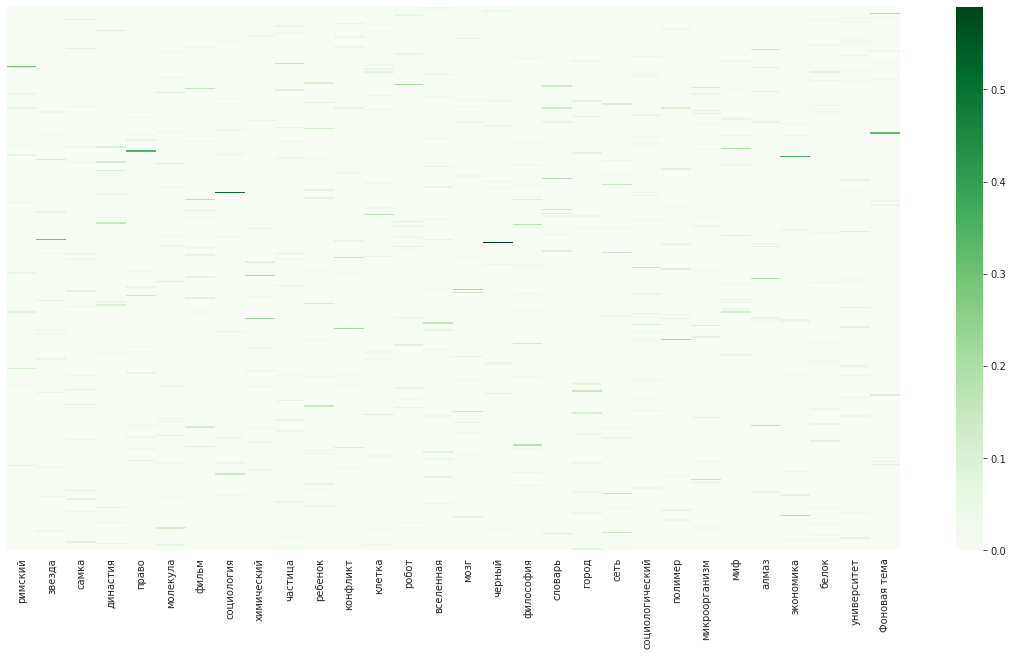

In [25]:
# Ваш код
plt.figure(figsize=(20, 10))
sbs.heatmap(phi_a, cmap='Greens', xticklabels=topic_labels, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [40]:
phi_a[(phi_a.sum(axis=1) > 0.01) & (phi_a.shape[1] - np.isclose(phi_a, 0).sum(axis=1) > 3)].rename(columns=dict(zip(phi_a.columns, topic_labels)))

,римский,звезда,самка,династия,право,молекула,фильм,социология,химический,частица,ребенок,конфликт,клетка,робот,вселенная,мозг,черный,философия,словарь,город,сеть,социологический,полимер,микроорганизм,миф,алмаз,экономика,белок,университет,Фоновая тема
Владимир_Плунгян,0.068297,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.063371,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.132170,0.0,0.000000,0.000000e+00,0.105810,0.000000,1.020676e-16,0.000000,0.000000,0.000000,0.000000,0.0
Фуад_Алескеров,0.000000,0.000000,1.401619e-07,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000200,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.362425,0.000000,0.001827,0.0
Кирилл_Еськов,0.000000,0.104633,1.217248e-05,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.019436,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.018339,0.000000,0.0
Александр_Воеводский,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.008674,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000012,0.025055,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,3.057019e-02,0.000000,0.000000,0.000000,0.000000,0.0
Алексей_Козырев,0.006394,0.000000,0.000000e+00,0.001939,0.000000,0.000000e+00,0.0,2.908075e-16,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.173742,0.000000,0.0,0.000000,1.215128e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
Эмиль_Ахмедов,0.000000,0.033849,6.023308e-02,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.076913,0.000000,0.000000,0.0,0.000000,1.238823e-10,0.000000,0.000000,0.000000,0.000025,0.0,0.000000,0.000000e+00,0.001931,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
Александр_Филиппов,0.000000,0.000000,1.166659e-04,0.000000,0.000000,0.000000e+00,0.0,1.777138e-02,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.851543e-02,0.002115,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
Артем_Оганов,0.000000,0.000015,0.000000e+00,0.000000,0.000000,7.548126e-03,0.0,0.000000e+00,0.210667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.068218,0.000000,0.000000e+00,0.056813,0.000123,0.000000,0.000000,0.0
Дмитрий_Паращук,0.000000,0.000000,3.665570e-02,0.000000,0.000000,2.104974e-14,0.0,0.000000e+00,0.000002,0.023856,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.041138,0.0
Дмитрий_Громов,0.000000,0.000000,2.178561e-02,0.000000,0.000285,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.068398,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000017,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [28]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [0]:
p_a_t = phi_a 
p_t = theta.sum(axis=1) / theta.values.sum()

P = (phi_a * p_t) / (p_a_t * p_t).sum(axis=1).values.reshape((-1, 1))
P.rename(columns=dict(zip(P.columns, topic_labels)), inplace=True)

In [60]:
P.shape

(392, 30)

In [62]:
# Ваш код
%%time
similarities = pairwise_distances(P, n_jobs=-1, metric='cosine')

CPU times: user 15.8 ms, sys: 84.1 ms, total: 99.9 ms
Wall time: 108 ms


In [65]:
%%time
embedding = MDS(n_components=2, dissimilarity='precomputed', n_jobs=-1)
T_similarities = embedding.fit_transform(phi_a_dist)

CPU times: user 56.2 ms, sys: 40.4 ms, total: 96.6 ms
Wall time: 2.91 s


Визуализируйте найденные двумерные представления с помощью функции scatter. 

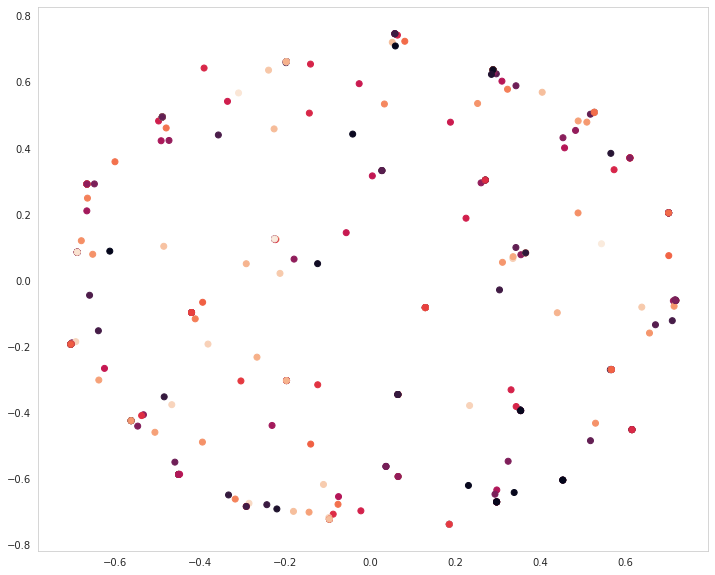

In [81]:
plt.figure(figsize=(12, 10))
plt.scatter(T_similarities[:, 0], T_similarities[:, 1], c=np.random.rand(T_similarities.shape[0]))

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

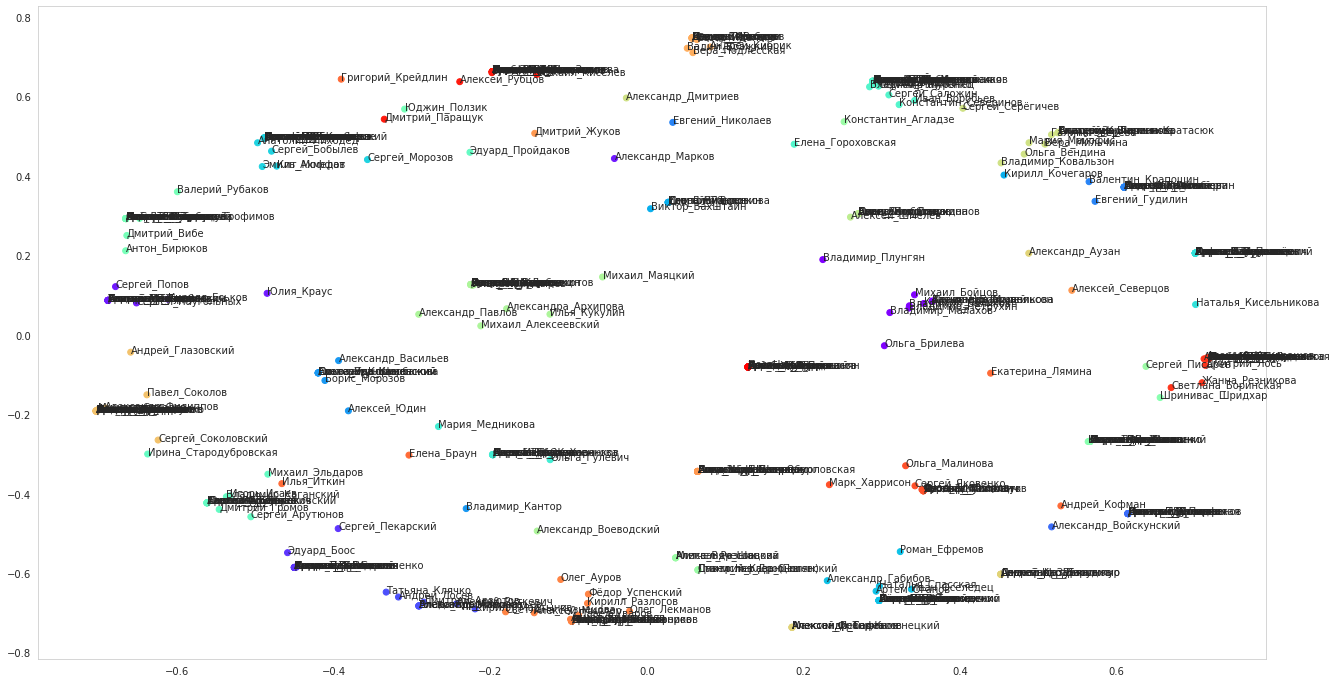

In [105]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, P.shape[1])) # цвета для тем
# Ваш код
plt.figure(figsize=(22, 12))
plt.scatter(T_similarities[:, 0], T_similarities[:, 1], c=colors[np.argmax(P.values, axis=1)])
for coords, text in zip(T_similarities, phi_a.index):
  plt.annotate(text, xy=coords)

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [0]:
# Ваш код
P = theta / theta.sum(axis=1).values.reshape((-1, 1))
P = np.argsort(P.values, axis=1)[:, ::-1]

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [119]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [122]:
from IPython.core.display import display, HTML
display(HTML("<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML("<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML('<font color="green">Зеленый!</font>'))
display(HTML('<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

**bold text**

In [162]:
# Ваш код
for i, (topic_name, top_tokens) in enumerate(zip(topic_labels, model_artm.score_tracker['text_toptokenscore'].last_tokens.values())):
  display(HTML('<h4>%s</h4>' % topic_name))
  display(HTML('<ul><li>%s</li></ul>' % ' '.join(top_tokens[:10])))
  print(theta.columns[P[i][:10]].tolist())

['http://postnauka.ru/video/13041', 'http://postnauka.ru/video/17414', 'http://postnauka.ru/video/17875', 'http://postnauka.ru/video/11509', 'http://postnauka.ru/video/23472', 'http://postnauka.ru/video/30662', 'http://postnauka.ru/video/3348', 'http://postnauka.ru/video/41335', 'http://postnauka.ru/video/17912', 'http://postnauka.ru/video/14292']


['http://postnauka.ru/video/31695', 'http://postnauka.ru/video/27831', 'http://postnauka.ru/video/37994', 'http://postnauka.ru/video/2959', 'http://postnauka.ru/video/36249', 'http://postnauka.ru/video/1817', 'http://postnauka.ru/video/10786', 'http://postnauka.ru/video/31664', 'http://postnauka.ru/video/32889', 'http://postnauka.ru/video/38001']


['http://postnauka.ru/video/3602', 'http://postnauka.ru/video/31684', 'http://postnauka.ru/video/41348', 'http://postnauka.ru/video/34426', 'http://postnauka.ru/video/36804', 'http://postnauka.ru/video/24294', 'http://postnauka.ru/video/37982', 'http://postnauka.ru/video/1856', 'http://postnauka.ru/video/19457', 'http://postnauka.ru/video/28557']


['http://postnauka.ru/video/11034', 'http://postnauka.ru/video/3418', 'http://postnauka.ru/video/40000', 'http://postnauka.ru/video/25093', 'http://postnauka.ru/video/37990', 'http://postnauka.ru/video/31666', 'http://postnauka.ru/video/15043', 'http://postnauka.ru/video/13180', 'http://postnauka.ru/video/33797', 'http://postnauka.ru/video/3423']


['http://postnauka.ru/video/31688', 'http://postnauka.ru/video/38009', 'http://postnauka.ru/video/34414', 'http://postnauka.ru/video/17913', 'http://postnauka.ru/video/32632', 'http://postnauka.ru/video/15982', 'http://postnauka.ru/video/41100', 'http://postnauka.ru/video/12574', 'http://postnauka.ru/video/36715', 'http://postnauka.ru/video/13744']


['http://postnauka.ru/video/21617', 'http://postnauka.ru/video/22592', 'http://postnauka.ru/video/31182', 'http://postnauka.ru/video/25882', 'http://postnauka.ru/video/12974', 'http://postnauka.ru/video/36490', 'http://postnauka.ru/video/18406', 'http://postnauka.ru/video/12971', 'http://postnauka.ru/video/13160', 'http://postnauka.ru/video/24460']


['http://postnauka.ru/video/39723', 'http://postnauka.ru/video/22901', 'http://postnauka.ru/video/10759', 'http://postnauka.ru/video/21638', 'http://postnauka.ru/video/37996', 'http://postnauka.ru/video/28942', 'http://postnauka.ru/video/21286', 'http://postnauka.ru/video/30019', 'http://postnauka.ru/video/13541', 'http://postnauka.ru/video/37742']


['http://postnauka.ru/video/32637', 'http://postnauka.ru/video/21660', 'http://postnauka.ru/video/3628', 'http://postnauka.ru/video/3635', 'http://postnauka.ru/video/17878', 'http://postnauka.ru/video/2530', 'http://postnauka.ru/video/23295', 'http://postnauka.ru/video/3422', 'http://postnauka.ru/video/24445', 'http://postnauka.ru/video/27965']


['http://postnauka.ru/video/11646', 'http://postnauka.ru/video/13700', 'http://postnauka.ru/video/18048', 'http://postnauka.ru/video/23253', 'http://postnauka.ru/video/32668', 'http://postnauka.ru/video/24449', 'http://postnauka.ru/video/12259', 'http://postnauka.ru/video/30655', 'http://postnauka.ru/video/19086', 'http://postnauka.ru/video/26207']


['http://postnauka.ru/video/13043', 'http://postnauka.ru/video/24434', 'http://postnauka.ru/video/2945', 'http://postnauka.ru/video/26515', 'http://postnauka.ru/video/18873', 'http://postnauka.ru/video/14283', 'http://postnauka.ru/video/31210', 'http://postnauka.ru/video/22760', 'http://postnauka.ru/video/19458', 'http://postnauka.ru/video/19460']


['http://postnauka.ru/video/30261', 'http://postnauka.ru/video/24279', 'http://postnauka.ru/video/22528', 'http://postnauka.ru/video/34413', 'http://postnauka.ru/video/40004', 'http://postnauka.ru/video/23470', 'http://postnauka.ru/video/25890', 'http://postnauka.ru/video/21646', 'http://postnauka.ru/video/25097', 'http://postnauka.ru/video/15972']


['http://postnauka.ru/video/22892', 'http://postnauka.ru/video/11361', 'http://postnauka.ru/video/31580', 'http://postnauka.ru/video/27925', 'http://postnauka.ru/video/30678', 'http://postnauka.ru/video/22883', 'http://postnauka.ru/video/20874', 'http://postnauka.ru/video/37968', 'http://postnauka.ru/video/16157', 'http://postnauka.ru/video/33791']


['http://postnauka.ru/video/35461', 'http://postnauka.ru/video/17051', 'http://postnauka.ru/video/27434', 'http://postnauka.ru/video/26213', 'http://postnauka.ru/video/13746', 'http://postnauka.ru/video/11628', 'http://postnauka.ru/video/31205', 'http://postnauka.ru/video/27379', 'http://postnauka.ru/video/35058', 'http://postnauka.ru/video/18742']


['http://postnauka.ru/video/31705', 'http://postnauka.ru/video/2527', 'http://postnauka.ru/video/34424', 'http://postnauka.ru/video/24945', 'http://postnauka.ru/video/15343', 'http://postnauka.ru/video/18807', 'http://postnauka.ru/video/30606', 'http://postnauka.ru/video/31679', 'http://postnauka.ru/video/27955', 'http://postnauka.ru/video/27932']


['http://postnauka.ru/video/23502', 'http://postnauka.ru/video/10383', 'http://postnauka.ru/video/31193', 'http://postnauka.ru/video/30015', 'http://postnauka.ru/video/23506', 'http://postnauka.ru/video/25875', 'http://postnauka.ru/video/12372', 'http://postnauka.ru/video/25902', 'http://postnauka.ru/video/2971', 'http://postnauka.ru/video/33755']


['http://postnauka.ru/video/19509', 'http://postnauka.ru/video/12521', 'http://postnauka.ru/video/25267', 'http://postnauka.ru/video/33786', 'http://postnauka.ru/video/25891', 'http://postnauka.ru/video/27845', 'http://postnauka.ru/video/25524', 'http://postnauka.ru/video/1837', 'http://postnauka.ru/video/24182', 'http://postnauka.ru/video/27824']


['http://postnauka.ru/video/31707', 'http://postnauka.ru/video/17397', 'http://postnauka.ru/video/36253', 'http://postnauka.ru/video/36810', 'http://postnauka.ru/video/35150', 'http://postnauka.ru/video/40880', 'http://postnauka.ru/video/32898', 'http://postnauka.ru/video/11061', 'http://postnauka.ru/video/37732', 'http://postnauka.ru/video/40268']


['http://postnauka.ru/video/36581', 'http://postnauka.ru/video/12738', 'http://postnauka.ru/video/2529', 'http://postnauka.ru/video/32664', 'http://postnauka.ru/video/32906', 'http://postnauka.ru/video/26234', 'http://postnauka.ru/video/36976', 'http://postnauka.ru/video/17510', 'http://postnauka.ru/video/1850', 'http://postnauka.ru/video/1507']


['http://postnauka.ru/video/41192', 'http://postnauka.ru/video/36272', 'http://postnauka.ru/video/40870', 'http://postnauka.ru/video/36708', 'http://postnauka.ru/video/34409', 'http://postnauka.ru/video/30632', 'http://postnauka.ru/video/30017', 'http://postnauka.ru/video/26633', 'http://postnauka.ru/video/18012', 'http://postnauka.ru/video/21632']


['http://postnauka.ru/video/25283', 'http://postnauka.ru/video/38485', 'http://postnauka.ru/video/20394', 'http://postnauka.ru/video/37998', 'http://postnauka.ru/video/19067', 'http://postnauka.ru/video/28944', 'http://postnauka.ru/video/25895', 'http://postnauka.ru/video/30233', 'http://postnauka.ru/video/29992', 'http://postnauka.ru/video/29572']


['http://postnauka.ru/video/12515', 'http://postnauka.ru/video/13742', 'http://postnauka.ru/video/3388', 'http://postnauka.ru/video/24306', 'http://postnauka.ru/video/12172', 'http://postnauka.ru/video/29812', 'http://postnauka.ru/video/36239', 'http://postnauka.ru/video/32918', 'http://postnauka.ru/video/15344', 'http://postnauka.ru/video/34936']


['http://postnauka.ru/video/13538', 'http://postnauka.ru/video/11246', 'http://postnauka.ru/video/11634', 'http://postnauka.ru/video/12083', 'http://postnauka.ru/video/20720', 'http://postnauka.ru/video/12148', 'http://postnauka.ru/video/34963', 'http://postnauka.ru/video/12518', 'http://postnauka.ru/video/21318', 'http://postnauka.ru/video/36237']


['http://postnauka.ru/video/10473', 'http://postnauka.ru/video/36492', 'http://postnauka.ru/video/32901', 'http://postnauka.ru/video/40887', 'http://postnauka.ru/video/38347', 'http://postnauka.ru/video/32669', 'http://postnauka.ru/video/23892', 'http://postnauka.ru/video/37970', 'http://postnauka.ru/video/31213', 'http://postnauka.ru/video/12524']


['http://postnauka.ru/video/32635', 'http://postnauka.ru/video/30673', 'http://postnauka.ru/video/16821', 'http://postnauka.ru/video/36719', 'http://postnauka.ru/video/33793', 'http://postnauka.ru/video/33788', 'http://postnauka.ru/video/3352', 'http://postnauka.ru/video/40882', 'http://postnauka.ru/video/2531', 'http://postnauka.ru/video/31671']


['http://postnauka.ru/video/10477', 'http://postnauka.ru/video/24034', 'http://postnauka.ru/video/1893', 'http://postnauka.ru/video/24039', 'http://postnauka.ru/video/21631', 'http://postnauka.ru/video/24030', 'http://postnauka.ru/video/12290', 'http://postnauka.ru/video/2946', 'http://postnauka.ru/video/25900', 'http://postnauka.ru/video/12517']


['http://postnauka.ru/video/27944', 'http://postnauka.ru/video/15341', 'http://postnauka.ru/video/40001', 'http://postnauka.ru/video/24461', 'http://postnauka.ru/video/35038', 'http://postnauka.ru/video/12375', 'http://postnauka.ru/video/19451', 'http://postnauka.ru/video/31682', 'http://postnauka.ru/video/40275', 'http://postnauka.ru/video/17416']


['http://postnauka.ru/video/12374', 'http://postnauka.ru/video/28282', 'http://postnauka.ru/video/15975', 'http://postnauka.ru/video/27823', 'http://postnauka.ru/video/10382', 'http://postnauka.ru/video/28278', 'http://postnauka.ru/video/28290', 'http://postnauka.ru/video/24457', 'http://postnauka.ru/video/41350', 'http://postnauka.ru/video/36350']


['http://postnauka.ru/video/10779', 'http://postnauka.ru/video/10754', 'http://postnauka.ru/video/19436', 'http://postnauka.ru/video/38011', 'http://postnauka.ru/video/12383', 'http://postnauka.ru/video/22332', 'http://postnauka.ru/video/39997', 'http://postnauka.ru/video/27963', 'http://postnauka.ru/video/24075', 'http://postnauka.ru/video/28946']


['http://postnauka.ru/video/2973', 'http://postnauka.ru/video/21125', 'http://postnauka.ru/video/31200', 'http://postnauka.ru/video/27835', 'http://postnauka.ru/video/25326', 'http://postnauka.ru/video/31198', 'http://postnauka.ru/video/26607', 'http://postnauka.ru/video/36494', 'http://postnauka.ru/video/25884', 'http://postnauka.ru/video/23776']


['http://postnauka.ru/video/20388', 'http://postnauka.ru/video/16169', 'http://postnauka.ru/video/12376', 'http://postnauka.ru/video/16159', 'http://postnauka.ru/video/27946', 'http://postnauka.ru/video/27083', 'http://postnauka.ru/video/36857', 'http://postnauka.ru/video/18006', 'http://postnauka.ru/video/2722', 'http://postnauka.ru/video/36707']


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 